In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mp
import sklearn
from IPython.display import Image

%matplotlib inline

# Dimensionality Reduction and PCA -- SVD II

In the last lecture we learned about the SVD as a tool for constructing low-rank matrices.

Today we'll look at it as a way to transform our data objects.

As a reminder, here is what the SVD looks like:

$$ \mbox{objects}\left\{\begin{array}{c}\;\\\;\\\;\\\;\\\;\end{array}\right.\;\;\overbrace{\left[\begin{array}{cccc}\begin{array}{c}\vdots\\\vdots\\{\bf a_1}\\\vdots\\\vdots\end{array}&\begin{array}{c}\vdots\\\vdots\\{\bf a_2}\\\vdots\\\vdots\end{array}&\dots&\begin{array}{c}\vdots\\\vdots\\{\bf a_n}\\\vdots\\\vdots\end{array}\\\end{array}\right]}^{\mbox{features}} =
\overbrace{\left[\begin{array}{cc}\vdots&\vdots\\\vdots&\vdots\\\sigma_1\mathbf{u}_1&\sigma_k\mathbf{u}_k\\\vdots&\vdots\\\vdots&\vdots\end{array}\right]}^{\large k}
\times
\left[\begin{array}{ccccc}\dots&\dots&\mathbf{v}_1&\dots&\dots\\\dots&\dots&\mathbf{v}_k&\dots&\dots\end{array}\right]$$


$$ A = U\Sigma V^T$$

Notice that $U$ contains a row for each object.   

In a sense we have transformed objects from an $n$ dimensional space to a $k$ dimensional space, where $k$ is (probably much) smaller than $n$.

This is an example of __dimensionality reduction.__

When we take our data to be the rows of $U\Sigma$ instead of rows of $A$, we are __reducing the dimension__ of our data from $n$ dimensions to $k$ dimensions.

This suggests an idea: is there an __optimal__ transformation of the data into $k$ dimensions?
    
What would that mean?

```{note}
An excellent reference for the following section is 
https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/.
Some figures and discusion are taken from there.
```

<!-- https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/ -->

Here is a natural criterion for the "best" $k$-dimensional transformation:

__Find the $k$-dimensional hyperplane that is "closest" to the points.__

More precisely:

Given n points in $\mathbb{R}^n$, find the hyperplane (affine space) of dimension $k$ with the property that the squared distance of the points to their orthogonal projection onto the hyperplane is minimized.

<center>
    
<img src="figs/pca_figure1.jpeg" alt="Figure" width="40%">
    
</center>

<!-- Source: https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/ -->

This sounds like an appealing criterion.   

But it also turns out to have a strong statistical guarantee.

In fact, this criterion is a transformation that captures the maximum __variance__ in the data.

That is, the resulting $k$-dimensional dataset is the one with maximum variance.

Let's see why this is the case.

First, let's recall the idea of a dataset __centroid.__

Given a $n\times d$ data matrix $X$ with observations on the rows (as always):
    
then 

$$\overline{\mathbf{x}}^T = \frac{1}{n}\mathbf{1}^TX.$$

In words: the centroid -- ie, the mean vector -- is the average over the rows.

It is the "center of mass" of the dataset.

Next, recall the sample variance of a dataset is:
    
$$ \operatorname{Var}(X) = \frac{1}{n}\sum_j\Vert \mathbf{x}_j^T - \overline{\mathbf{x}}^T\Vert^2 $$

where $\mathbf{x}_j^T$ is row $j$ of $X$.

In other words, the sample variance of the set of points is the average squared distance from each point to the centroid. 

Consider if we move the points (translate each point by some constant amount).   Clearly, the sample variance does not change.

So, let's move the points to be __centered__ on the __origin.__

$$ \tilde{X} = X - \mathbf{1}\overline{\mathbf{x}}^T $$

The sample variance of the new points $\tilde{X}$ is the same as the old points $X$, but the centroid of the new point set is the origin.

Now that the mean of the points is the zero vector, we can reason geometrically.

Here is a picture to show why the distance-minimizing subspace is variance-maximizing.

In this figure,   
* the red point is one example point from $\tilde{X}$, 
* the green point is the origin / centroid, and
* the blue point is the $k$-dimensional projection of the red point.

<center>
    
<img src="figs/pca_figure5.jpeg" alt="Figure" width="40%">
    
</center>

<!-- Source: https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/ -->

The length of the black line is fixed -- it is the distance of the original point from the origin.

So the squared length of the black line is this point's contribution to the sample variance.

Now, regardless of how we shift the green line, a right triangle is formed because the projection is orthogonal. 

So -- by virtue of the Pythagorean Theorem, the __blue line squared__ plus the __red line squared__ equals the __black line squared.__

Which means that when we shift the subspace (green line) so as to __minimize the squared distances to all the example points__ $\tilde{X}$ (blue lines) we automatically __maximize the squared distance of all the resulting blue points to the origin__ (red lines).

And the squared distance of the blue point from the origin (red dashed line) is its contribution to the new $k$-dimensional sample variance.

In other words, the __distance-minimizing__ projection is the __variance-maximizing__ projection!

In [2]:
def centerAxes(ax):
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    bounds = np.array([ax.axes.get_xlim(), ax.axes.get_ylim()])
    ax.plot(bounds[0][0],bounds[1][0],'')
    ax.plot(bounds[0][1],bounds[1][1],'')

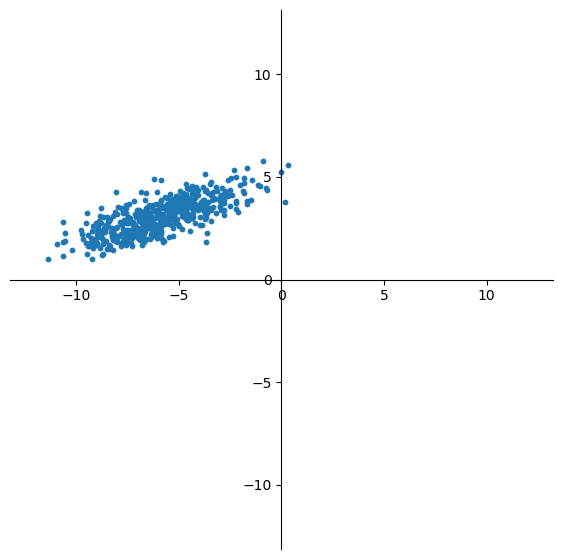

In [3]:
n_samples = 500
C = np.array([[0.1, 0.6], [2., .6]])
X = np.random.randn(n_samples, 2) @ C + np.array([-6, 3])
ax = plt.figure(figsize = (7, 7)).add_subplot()
plt.xlim([-12, 12])
plt.ylim([-7, 7])
centerAxes(ax)
plt.axis('equal')
plt.scatter(X[:, 0], X[:, 1], s=10, alpha=1);

For example, here is a dataset $X$ in $\mathbb{R}^2$.

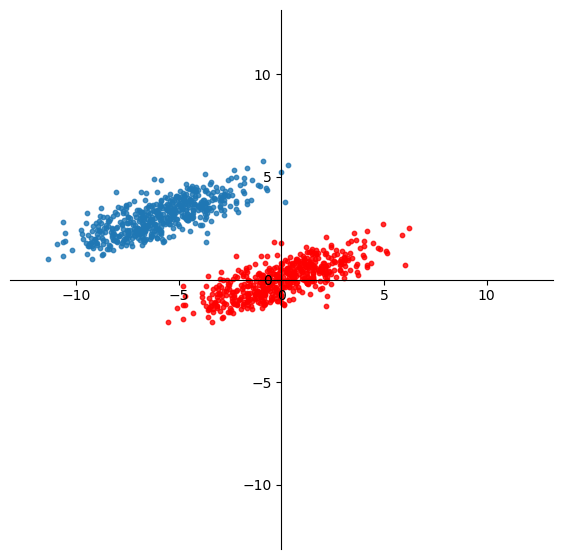

In [4]:
Xc = X - np.mean(X,axis=0)
ax = plt.figure(figsize = (7, 7)).add_subplot()
plt.xlim([-12, 12])
plt.ylim([-7, 7])
centerAxes(ax)
plt.axis('equal')
plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.8)
plt.scatter(Xc[:, 0], Xc[:, 1], s=10, alpha=0.8, color='r');

By taking 

$$ \tilde{X} = X - \mathbf{1}\overline{\mathbf{x}}^T $$

we translate each point so that the new mean is the origin.

Now, the last step is to find the $k$-dimensional subspace that minimizes the distance between the data (red points) and their projection on the subspace.

Remember that $\ell_2$ norm of a vector difference is Euclidean distance.

In other words, what rank $k$ matrix $X^{(k)} \in \mathbb{R}^{n\times k}$ is closest to $\tilde{X}$?

We seek

$$X^{(k)} =\arg \min_{\{B\;|\;\operatorname{Rank} B = k\}} \Vert \tilde{X}-B\Vert_F.$$

We know how to find this matrix -- 

as we showed in the last lecture, we obtain it via the SVD!

So for this case, let's construct the best 1-D approximation of the mean-centered data:

In [5]:
Xc = X - np.mean(X, axis = 0)
u, s, vt = np.linalg.svd(Xc, full_matrices=False)
scopy = s.copy()
scopy[1] = 0.
reducedX = u @ np.diag(scopy) @ vt

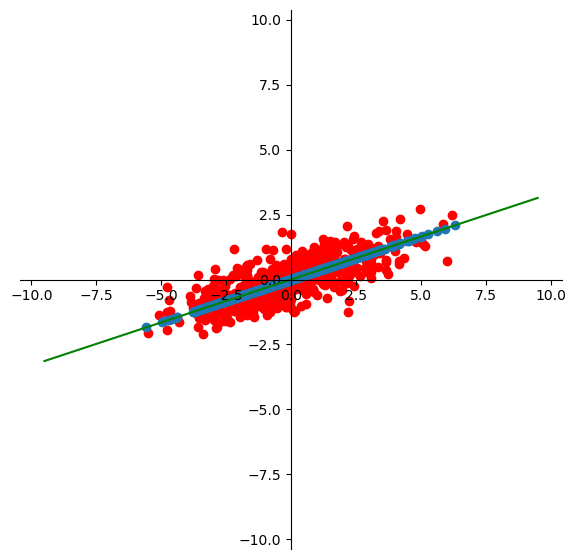

In [6]:
ax = plt.figure(figsize = (7, 7)).add_subplot()
centerAxes(ax)
plt.axis('equal')
plt.scatter(Xc[:,0],Xc[:,1], color='r')
plt.scatter(reducedX[:,0], reducedX[:,1])
endpoints = np.array([[-10],[10]]) @ vt[[0],:]
plt.plot(endpoints[:,0], endpoints[:,1], 'g-');

This method is called __Principal Component Analysis.__

In summary, PCA consists of:

1. Mean center the data, and
2. Reduce the dimension of the mean-centered data via SVD.

This is equivalent to projecting the data onto the hyperplane that captures the maximum variance in the data.

It winds up constructing the __best low dimensional linear approximation of the data.__

What are "principal components"?

These are nothing more than the columns of $U$ (or the rows of $V^T$).  Because they capture the direction of maximum variation, they are called "principal" components.

## Uses of PCA/SVD

There are many uses of PCA (and SVD).

We'll cover three of the main uses:

1. Visualization
2. Denoising
3. Anomaly Detection

As already mentioned, SVD is also useful for data compression -- we won't discuss it in detail, but it is the principle behind audio and video compression (MP3s, HDTV, etc).

## Visualization and Denoising -- Extended Example.

We will study both visualization and denoising in the context of text processing.

As we have seen, a common way to work with documents is using the bag-of-words model (perhaps considering n-grams), which results in a term-document matrix.

Entries in the matrix are generally TF-IDF scores.

Often, terms are correlated -- they appear together in combinations that suggest a certain "concept".

That is, term-document matrices often show low effective rank -- many columns can be approximated as combinations of other columns.

When PCA is used for dimensionality reduction of documents, it tends to to extract these "concept" vectors.

The application of PCA to term-document matrices is called __Latent Semantic Analysis (LSA).__

Among other benefits, LSA can improve the performance of clustering of documents.

This happens because the important concepts are captured in the most significant principal components.

## Data: 20 Newsgroups

In [7]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.os.ms-windows.misc', 'sci.space','rec.sport.baseball']
news_data = fetch_20newsgroups(subset='train', categories=categories)

In [8]:
print(news_data.target_names)
print(news_data.target)

['comp.os.ms-windows.misc', 'rec.sport.baseball', 'sci.space']
[2 0 0 ... 2 1 2]


### Basic Clustering

To get started, let's compute tf-idf scores.

Notice that we will let the tokenizer compute $n$-grams for $n=$1 and 2.  

An $n$-gram is a set of $n$ consecutive terms.

We'll compute a document-term matrix `dtm`.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)
dtm = vectorizer.fit_transform(news_data.data)

In [10]:
print(type(dtm), dtm.shape)
terms = vectorizer.get_feature_names_out()

<class 'scipy.sparse._csr.csr_matrix'> (1781, 9409)


As a comparison case, let's first cluster the documents using the raw tf-idf scores.

(This is without any use of PCA, and so includes lots of noisy or meaningless terms.)

In [11]:
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state = 0)
kmeans.fit_predict(dtm)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

Let's evaluate the clusters.  We'll assume that the newgroup the article came from is the 'ground truth.'

In [12]:
import sklearn.metrics as metrics
ri = metrics.adjusted_rand_score(labels,news_data.target)
ss = metrics.silhouette_score(dtm,kmeans.labels_,metric='euclidean')
print('Rand Index is {}'.format(ri))
print('Silhouette Score is {}'.format(ss))

Rand Index is 0.7203279994023624
Silhouette Score is 0.009377353619567392


### Improvement: Stemming

One source of noise that we can eliminate (before we use LSA) comes from word endings.

For example: a Google search on 'run' will return web pages on 'running.'

This is useful, because the difference between 'run' and 'running' in practice is not enough to matter.

The usual solution taken is to simply 'chop off' the part of the word that indicates a variation from the base word.

(For those of you who studied Latin or Greek, this will sound familiar -- we are removing the 'inflection.')

The process is called 'stemming.'

A very good stemmer is the "Snowball" stemmer.

You can read more at http://www.nltk.org and http://www.nltk.org/howto/stem.html.

Installation Note: From a cell you need to call `nltk.download()` and select the appropriate packages from the interface that appears. In particular you need to download: `stopwords` from _corpora_ and `punkt` and `snowball_data` from _models._

Let's stem the data using the Snowball stemmer:

In [13]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize


stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
         for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in news_data.data]

dtm = vectorizer.fit_transform(stemmed_data)
terms = vectorizer.get_feature_names_out()

And now let's see how well we can cluster on the stemmed data.

In [14]:
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10,random_state=0)
kmeans.fit_predict(dtm)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

In [15]:
import sklearn.metrics as metrics
ri = metrics.adjusted_rand_score(labels,news_data.target)
ss = metrics.silhouette_score(dtm,kmeans.labels_,metric='euclidean')
print('Rand Index is {}'.format(ri))
print('Silhouette Score is {}'.format(ss))

Rand Index is 0.844864300823809
Silhouette Score is 0.01080754741232728


So the Rand Index went from 0.816 to 0.846 as a result of stemming.

## Demonstrating PCA

OK.  Now, let's apply PCA.

Our data matrix is in sparse form.



First, we mean center the data.
Note that `vectors` is a sparse matrix, but once it is mean centered it is not sparse any longer.

Then we use PCA to reduce the dimension of the mean-centered data.

In [16]:
dtm_dense = dtm.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
u, s, vt = np.linalg.svd(centered_dtm)

Note that if you have sparse data, you may want to use `scipy.sparse.linalg.svds()` and for large data it may be advantageous to use `sklearn.decomposition.TruncatedSVD()`.

$$ \mbox{objects}\left\{\begin{array}{c}\;\\\;\\\;\\\;\\\;\end{array}\right.\;\;\overbrace{\left[\begin{array}{cccc}\begin{array}{c}\vdots\\\vdots\\{\bf a_1}\\\vdots\\\vdots\end{array}&\begin{array}{c}\vdots\\\vdots\\{\bf a_2}\\\vdots\\\vdots\end{array}&\dots&\begin{array}{c}\vdots\\\vdots\\{\bf a_n}\\\vdots\\\vdots\end{array}\\\end{array}\right]}^{\mbox{features}} =
\overbrace{\left[\begin{array}{cc}\vdots&\vdots\\\vdots&\vdots\\\sigma_1\mathbf{u}_1&\sigma_k\mathbf{u}_k\\\vdots&\vdots\\\vdots&\vdots\end{array}\right]}^{\large k}
\times
\left[\begin{array}{ccccc}\dots&\dots&\mathbf{v}_1&\dots&\dots\\\dots&\dots&\mathbf{v}_k&\dots&\dots\end{array}\right]$$


$$ A = U\Sigma V^T$$

The principal components (rows of $V^T$) encode the extracted concepts.

Each LSA __concept__ is a linear combination of words.

In [17]:
pd.DataFrame(vt, columns=vectorizer.get_feature_names_out())

,00,000,0005,0062,0096b0f0,00bjgood,00mbstultz,01,0114,01wb,...,zri,zrlk,zs,zt,zu,zv,zw,zx,zy,zz
0,0.007831,0.012323,0.000581,0.005558,0.001032,0.002075,0.002008,0.005575,0.001247,0.000813,...,-0.000028,-0.000025,-0.000200,-0.000025,-0.000128,-0.000207,-0.000087,-0.000150,-0.000113,0.000534
1,-0.005990,0.009540,0.002089,-0.010679,-0.001646,-0.003477,-0.002687,0.002143,-0.003394,0.002458,...,-0.000015,-0.000013,-0.000054,-0.000013,-0.000042,-0.000100,-0.000026,-0.000064,-0.000040,-0.001041
2,-0.012630,-0.011904,-0.002443,0.001438,0.000439,0.000044,0.000349,-0.006817,0.000692,-0.001124,...,-0.000095,-0.000086,-0.000289,-0.000087,-0.000252,-0.000576,-0.000134,-0.000293,-0.000204,-0.000013
3,0.013576,0.017639,0.003552,0.001148,0.003354,-0.000410,0.000622,0.011649,0.002237,0.001969,...,0.000205,0.000186,0.000486,0.000172,0.000464,0.001142,0.000220,0.000508,0.000352,0.000200
4,-0.002254,-0.004619,-0.005458,-0.001938,-0.000251,0.000689,0.000043,-0.002620,-0.000533,0.001434,...,-0.000310,-0.000283,-0.000775,-0.000252,-0.000698,-0.001714,-0.000331,-0.000728,-0.000529,-0.000961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8048,0.000043,-0.000048,-0.000207,0.000041,-0.002082,-0.000734,-0.000556,0.000508,-0.000423,-0.000179,...,-0.001449,-0.002007,0.000133,-0.000929,0.000642,0.976204,-0.000030,0.000284,-0.000042,0.000657
8049,0.000137,0.000255,-0.000053,-0.000149,0.001295,-0.000098,-0.000018,-0.000708,-0.000041,-0.000346,...,0.000114,0.000102,-0.000522,-0.000170,-0.001086,-0.000132,0.999364,-0.000520,-0.000747,-0.000892
8050,-0.000186,0.000999,-0.000025,-0.000613,-0.000284,-0.000495,-0.000221,0.000041,0.000112,0.000328,...,0.000246,0.000210,-0.001592,-0.000179,-0.000888,0.000155,-0.000515,0.996858,-0.001115,0.000816
8051,0.000019,0.000606,-0.000161,-0.000327,0.000523,-0.000124,-0.000112,-0.000705,-0.000055,0.000097,...,0.000202,0.000184,-0.000606,-0.000288,-0.001271,-0.000157,-0.000769,-0.001136,0.998706,-0.000867


In [18]:
names = np.array(vectorizer.get_feature_names_out())
for cl in range(3):
    print(f'\nPrincipal Component {cl}:')
    idx = np.array(np.argsort(vt[cl]))[0][-10:]
    for i in idx[::-1]:
        print(f'{names[i]:12s} {vt[cl, i]:0.3f}')


Principal Component 0:
year         0.140
game         0.111
henri        0.108
team         0.107
space        0.106
nasa         0.091
toronto      0.086
alaska       0.083
player       0.079
hit          0.077

Principal Component 1:
space        0.260
nasa         0.218
henri        0.184
gov          0.135
orbit        0.134
alaska       0.129
access       0.129
toronto      0.118
launch       0.109
digex        0.102

Principal Component 2:
henri        0.458
toronto      0.364
zoo          0.228
edu          0.201
spencer      0.194
zoolog       0.184
alaska       0.123
work         0.112
umd          0.096
utzoo        0.092


The rows of $U$ correpond to documents, which are linear combinations of __concepts__.

## Denoising

In order to improve our clustering accuracy, we will __exclude__ the less significant concepts from the documents' feature vectors.

That is, we will choose the leftmost $k$ columns of $U$ and the topmost $k$ rows of $V^T$.  

The reduced set of columns of $U$ are our new document encodings, and it is those that we will cluster.

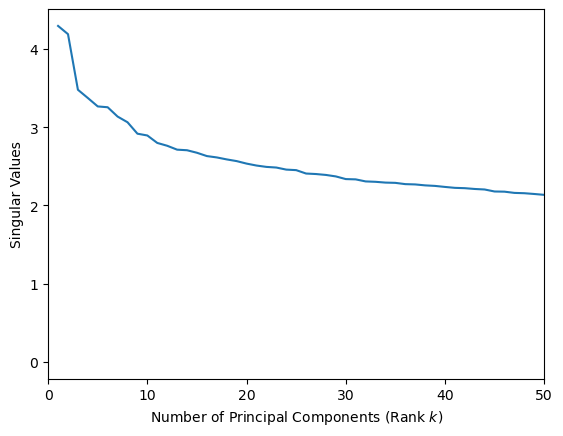

In [19]:
plt.xlim([0,50])
plt.xlabel('Number of Principal Components (Rank $k$)')
plt.ylabel('Singular Values')
plt.plot(range(1,len(s)+1), s);

It looks like 2 is a reasonable number of principal components.

In [22]:
ri = []
ss = []
max = len(u)
for k in range(1,50):
    vectorsk = np.asarray(u[:,:k] @ np.diag(s[:k]))
    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(vectorsk)
    labelsk = kmeans.labels_
    ri.append(metrics.adjusted_rand_score(labelsk,news_data.target))
    ss.append(metrics.silhouette_score(vectorsk,kmeans.labels_,metric='euclidean'))

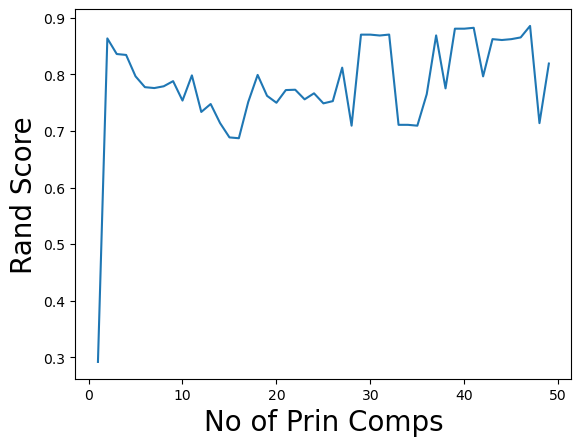

In [23]:
plt.plot(range(1,50),ri)
plt.ylabel('Rand Score',size=20)
plt.xlabel('No of Prin Comps',size=20);

In [24]:
news_data.target_names

['comp.os.ms-windows.misc', 'rec.sport.baseball', 'sci.space']

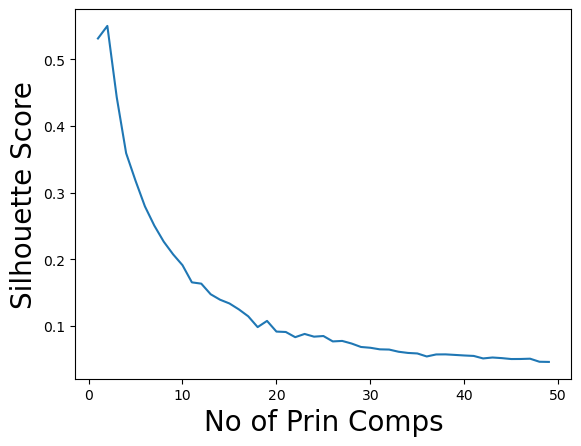

In [25]:
plt.plot(range(1,50),ss)
plt.ylabel('Silhouette Score', size=20)
plt.xlabel('No of Prin Comps', size=20);

Note that we can get good accuracy and coherent clusters with just __two__ principal components.

## Visualization

That's a good thing, because it means that we can also __visualize__ the data well with the help of PCA.

Recall that the challenge of visualization is that the data live in a high dimensional space.  

We can only look at 2 (or maybe 3) dimensions at a time, so it's not clear __which__ dimensions to look at.

The idea behind using PCA for visualization is that since low-numbered principal components capture most of the __variance__ in the data, these are the "directions" from which it is most useful to inspect the data.

We saw that the first two principal components were particularly large -- let's start by using them for visualization.

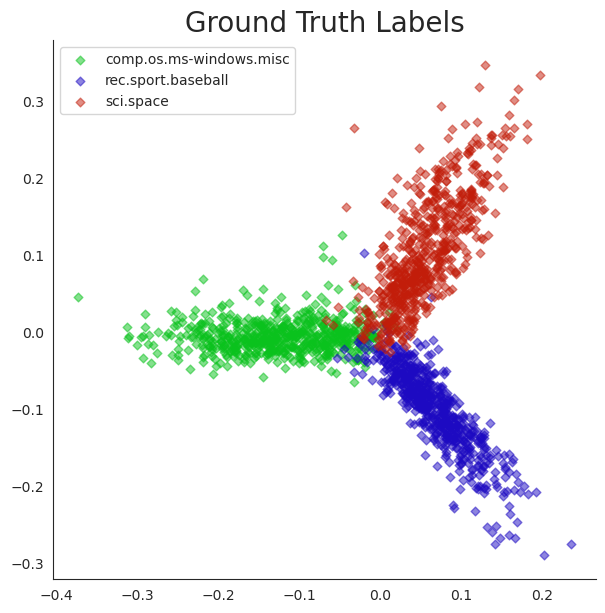

In [26]:
import seaborn as sns
Xk = u @ np.diag(s)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    cmap = sns.hls_palette(n_colors=3, h=0.35, l=0.4, s=0.9)
    for i, label in enumerate(set(news_data.target)):
        point_indices = np.where(news_data.target == label)[0]
        point_indices = point_indices.tolist()
        plt.scatter(np.ravel(Xk[point_indices, 0]), np.ravel(Xk[point_indices, 1]), s=20, alpha=0.5, color=cmap[i], marker='D',
label=news_data.target_names[i])
        plt.legend(loc = 'best')
    sns.despine()
plt.title('Ground Truth Labels', size=20);

Points in this plot have been labelled with their "true" (aka "ground truth") cluster labels.

Notice how clearly the clusters separate and how coherently they present themselves.   This is obvious an excellent visualization that is provided by PCA.

Since this visualization is so clear, we can use it to examine the results of our various clustering methods and get some insight into how they differ.

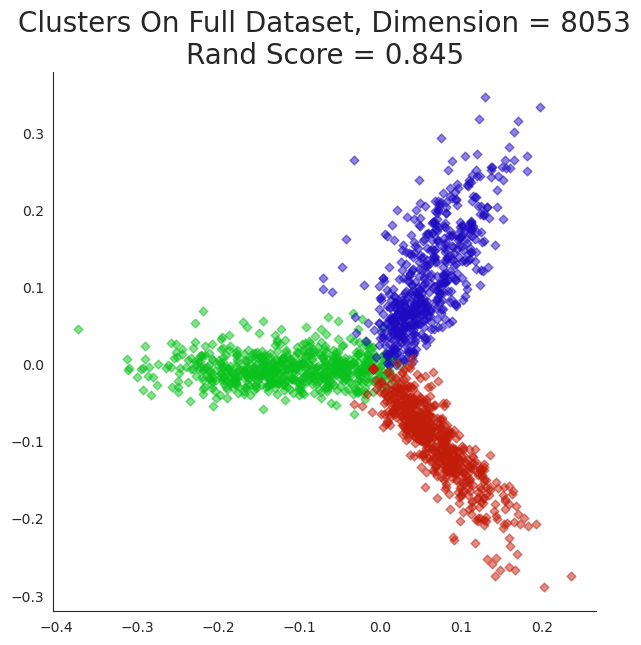

In [27]:
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10,random_state=0)
kmeans.fit_predict(dtm)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    cmap = sns.hls_palette(n_colors=3, h=0.35, l=0.4, s=0.9)
    for i in range(k):
        point_indices = np.where(labels == i)[0]
        point_indices = point_indices.tolist()
        plt.scatter(np.ravel(Xk[point_indices, 0]), np.ravel(Xk[point_indices, 1]), s=20, alpha=0.5, color=cmap[i], marker='D',
label=news_data.target_names[i])
    sns.despine()
plt.title('Clusters On Full Dataset, Dimension = {}\nRand Score = {:0.3f}'.format(dtm.shape[1],
                                                                             metrics.adjusted_rand_score(labels,news_data.target)),
          size=20);


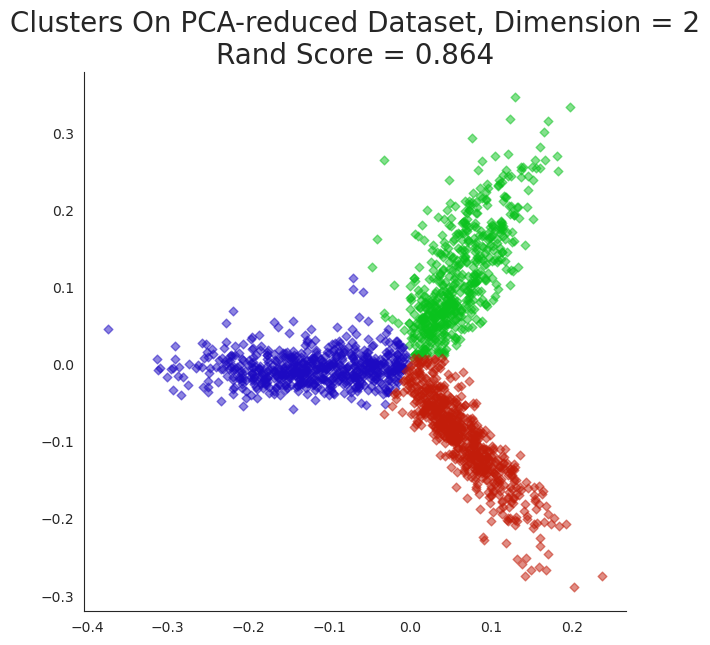

In [29]:
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10,random_state=0)
kmeans.fit_predict(np.asarray(Xk[:,:2]))
centroids = kmeans.cluster_centers_
Xklabels = kmeans.labels_
error = kmeans.inertia_

with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    cmap = sns.hls_palette(n_colors=3, h=0.35, l=0.4, s=0.9)
    for i, label in enumerate(set(news_data.target)):
        point_indices = np.where(Xklabels == label)[0]
        point_indices = point_indices.tolist()
        plt.scatter(np.ravel(Xk[point_indices,0]), np.ravel(Xk[point_indices,1]), s=20, alpha=0.5, color=cmap[i], marker='D')
    sns.despine()
plt.title('Clusters On PCA-reduced Dataset, Dimension = 2\nRand Score = {:0.3f}'.format(
                                                                                 metrics.adjusted_rand_score(Xklabels,news_data.target)),
          size=20);

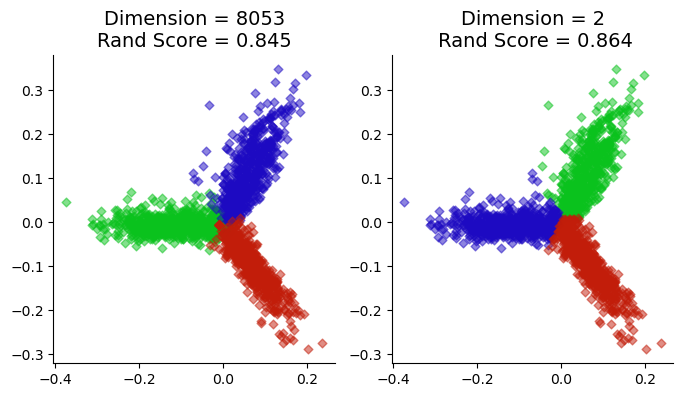

In [30]:
plt.figure(figsize=(8,4))
plt.subplot(121)
cmap = sns.hls_palette(n_colors=3, h=0.35, l=0.4, s=0.9)
for i in range(k):
        point_indices = np.where(labels == i)[0]
        point_indices = point_indices.tolist()
        plt.scatter(np.ravel(Xk[point_indices,0]), np.ravel(Xk[point_indices,1]), s=20, alpha=0.5, color=cmap[i], marker='D')
sns.despine()
plt.title('Dimension = {}\nRand Score = {:0.3f}'.format(dtm.shape[1],
                                                                             metrics.adjusted_rand_score(labels,news_data.target)),
          size=14)
plt.subplot(122)
cmap = sns.hls_palette(n_colors=3, h=0.35, l=0.4, s=0.9)
for i in range(k):
        point_indices = np.where(Xklabels == i)[0]
        point_indices = point_indices.tolist()
        plt.scatter(np.ravel(Xk[point_indices,0]), np.ravel(Xk[point_indices,1]), s=20, alpha=0.5, color=cmap[i], marker='D')
sns.despine()
plt.title('Dimension = 2\n Rand Score = {:0.3f}'.format(
                                                                                 metrics.adjusted_rand_score(Xklabels,news_data.target)),
          size=14);


What happens if we misjudge the number of clusters?  Let's form 6 clusters.

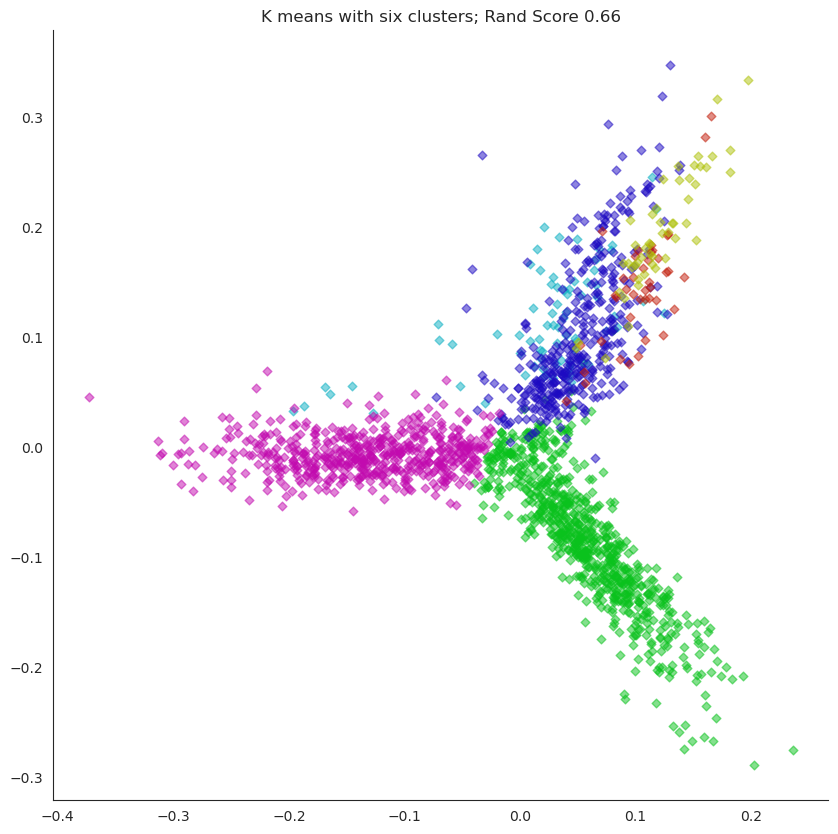

In [32]:
k = 6
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10,random_state=0)
kmeans.fit_predict(np.asarray(Xk[:,:6]))
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    cmap = sns.hls_palette(n_colors=k, h=0.35, l=0.4, s=0.9)
    for i in range(k):
        point_indices = np.where(labels == i)[0]
        point_indices = point_indices.tolist()
        plt.scatter(np.ravel(Xk[point_indices,0]), np.ravel(Xk[point_indices,1]), s=20, alpha=0.5, color=cmap[i], marker='D')
    sns.despine()

plt.title(f'K means with six clusters; Rand Score {metrics.adjusted_rand_score(labels,news_data.target):0.2f}');

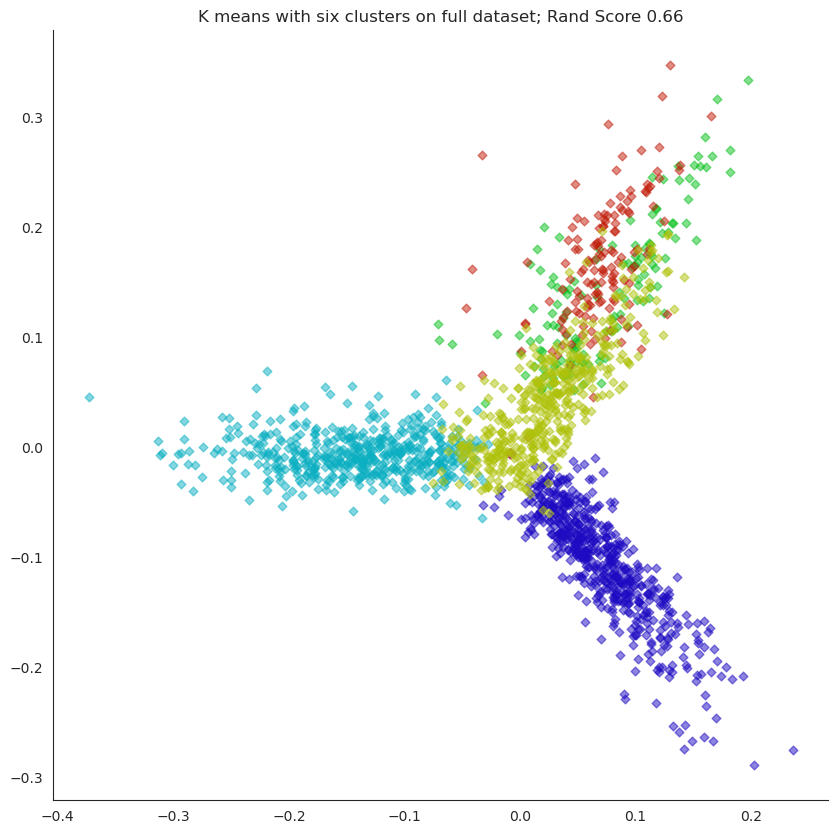

In [33]:
k = 6
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10,random_state=0)
kmeans.fit_predict(dtm)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    cmap = sns.hls_palette(n_colors=k, h=0.35, l=0.4, s=0.9)
    for i in range(k):
        point_indices = np.where(labels == i)[0]
        point_indices = point_indices.tolist()
        plt.scatter(np.ravel(Xk[point_indices,0]), np.ravel(Xk[point_indices,1]), s=20, alpha=0.5, color=cmap[i], marker='D')
    sns.despine()
plt.title('Clusters On Full Dataset, Dimension = {}'.format(dtm.shape[1]),size=20)
    
plt.title(f'K means with six clusters on full dataset; Rand Score {metrics.adjusted_rand_score(labels,news_data.target):0.2f}');

What about the other principal components?   Are they useful for visualization?

A common approach is to look at all pairs of (low-numbered) principal components, to look for additional structure in the data.

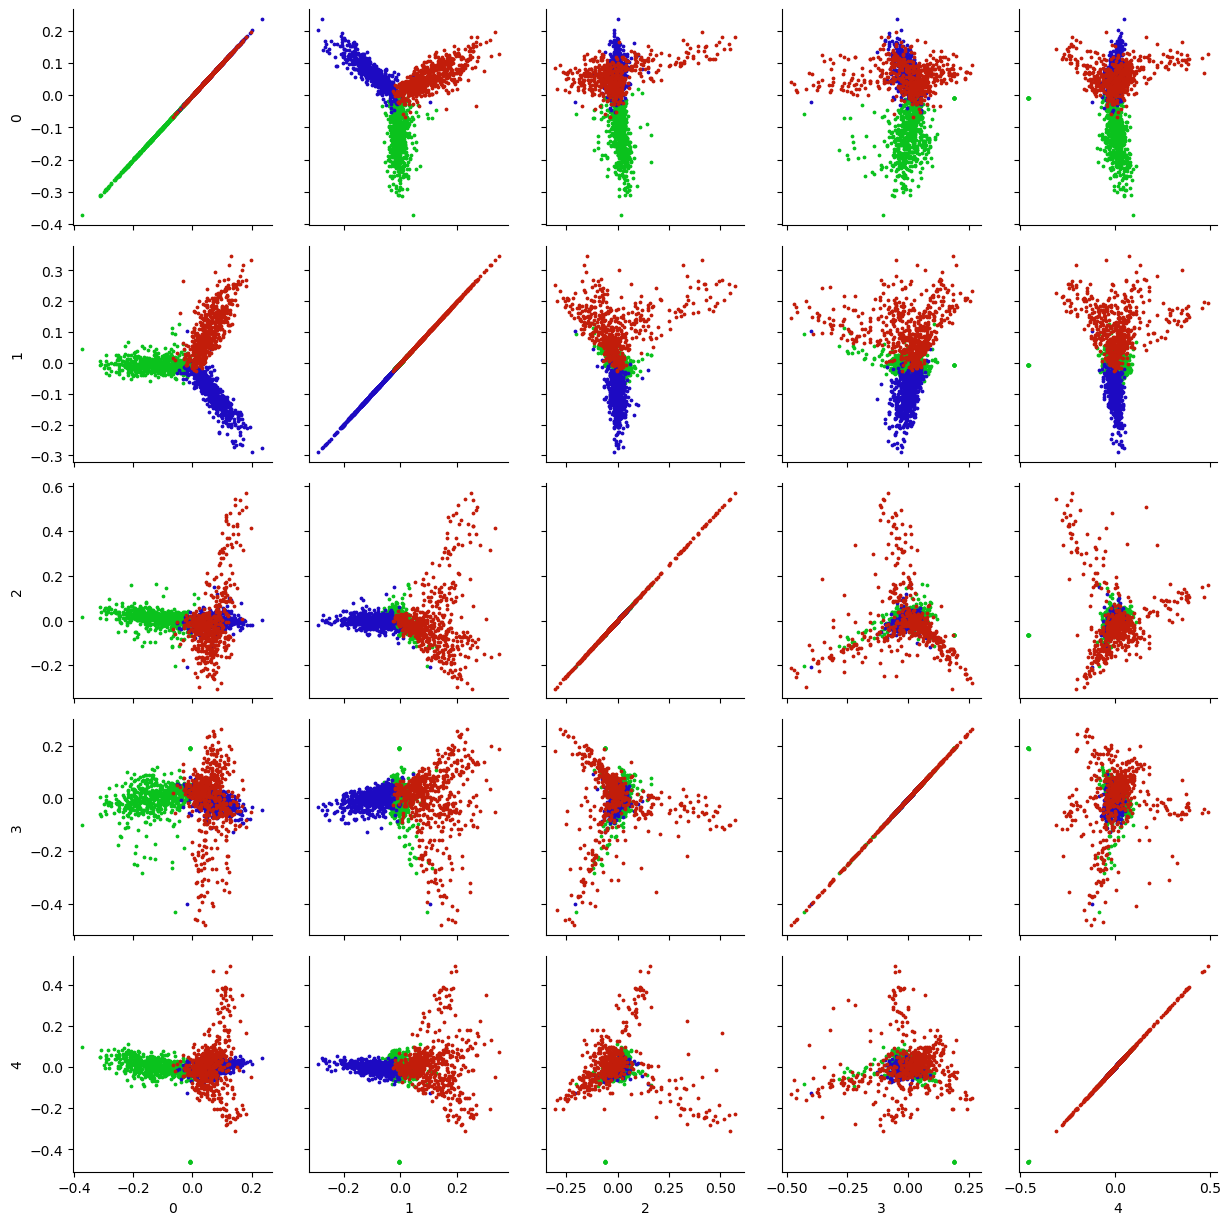

In [34]:
k = 5
Xk = u[:,:k] @ np.diag(s[:k])
X_df = pd.DataFrame(Xk)
g = sns.PairGrid(X_df)
def pltColor(x,y,color):
    cmap = sns.hls_palette(n_colors=3, h=0.35, l=0.4, s=0.9)
    for i in range(3):
        point_indices = np.where(news_data.target == i)[0]
        point_indices = point_indices.tolist()
        plt.scatter(x[point_indices], y[point_indices], color=cmap[i], s = 3)
    sns.despine()
g.map(pltColor);